    Time series analysis attempts to understand the past and predict the future of Nokia stock prices

In [18]:
#STOCK - NOKIA
#from pandas_datareader import data
import pandas as pd

#extract Nokia Stock prices data from various Internet sources into a pandas DataFrame
import pandas_datareader as web
import datetime
start = datetime.datetime(2009, 4, 1)
end = datetime.datetime(2019, 12, 1)
#Reading upto 10 years of Nokia stocks from Yahoo Finance
nok = web.DataReader('NOK', 'yahoo', start, end)
#Diplaying first 10 records
nok.head(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2009-04-01,12.19,11.46,11.48,12.11,18557300.0,7.709886
2009-04-02,13.62,12.70,12.78,13.18,28020900.0,8.391107
2009-04-03,13.18,12.65,13.01,13.16,13514100.0,8.378374
2009-04-06,13.33,12.93,13.05,13.29,17699300.0,8.461139
2009-04-07,12.71,12.46,12.52,12.64,15373700.0,8.047312
2009-04-08,13.31,12.77,12.81,13.26,19197800.0,8.442039
2009-04-09,13.81,13.50,13.56,13.80,18295600.0,8.785832
2009-04-13,14.13,13.44,13.44,14.03,13467100.0,8.932262
2009-04-14,14.08,13.60,13.70,13.80,14106900.0,8.785832


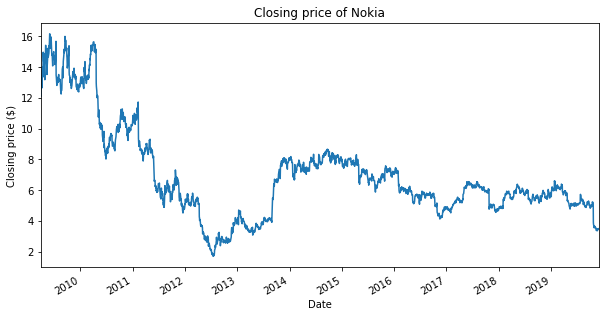

In [35]:
#Plotting the closing prices
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 5))
plt.title('Closing price of Nokia')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
cls = nok['Close']
cls.plot()

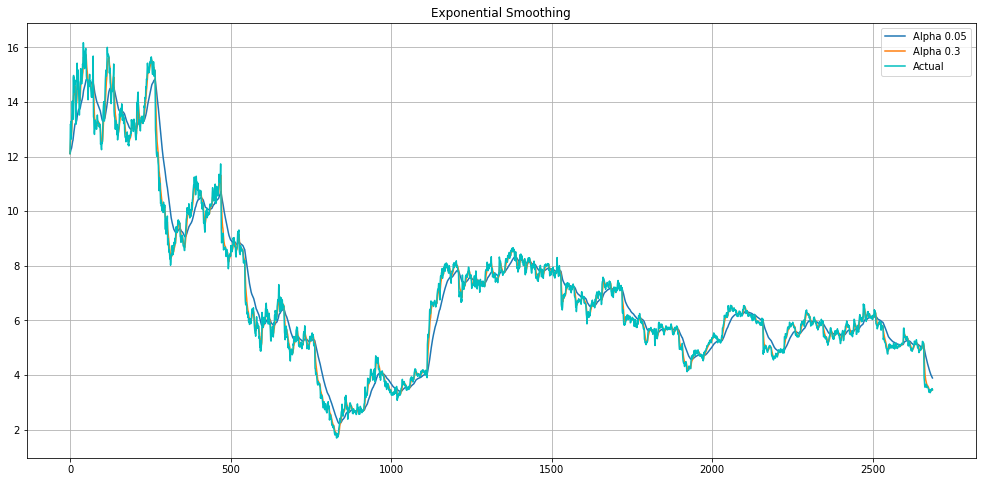

In [21]:
#Single Exponential Smoothing
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);
#Plotting exponential smoothing        
plot_exponential_smoothing(nok.Close, [0.05, 0.3])

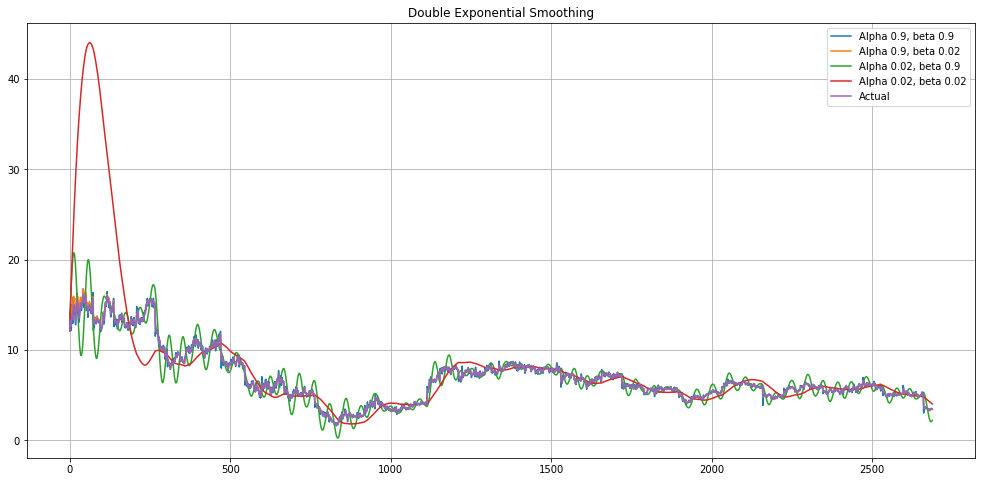

In [22]:
#Double Exponential Smoothing
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): 
            value = result[-1]
        else:
            value = series[n]
        
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

#Plotting the graph
def plot_double_exponential_smoothing(series, alphas, betas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

plot_double_exponential_smoothing(nok.Close, alphas=[0.9, 0.02], betas=[0.9, 0.02])

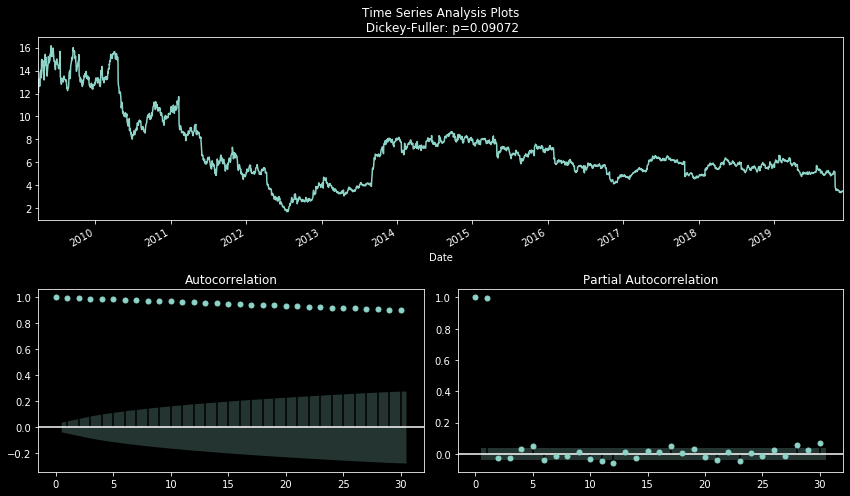

In [23]:
#Provides functions for statistical models and data exploration
import statsmodels.api as sm
import statsmodels as smt

def tsplot(y, lags=None, figsize=(12, 7), syle='dark_background'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='dark_background'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.tsaplots.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.tsaplots.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(nok.Close, lags=30)

In [24]:
#Time Series in not stationary and there is no evident seasonal behaviour and the autocorrelation is too high.

In [25]:
# Data transformations - Replacing spaces with _
nok.columns = [x.strip() for x in nok.columns]
nok.columns = [x.replace(' ', '_') for x in nok.columns]

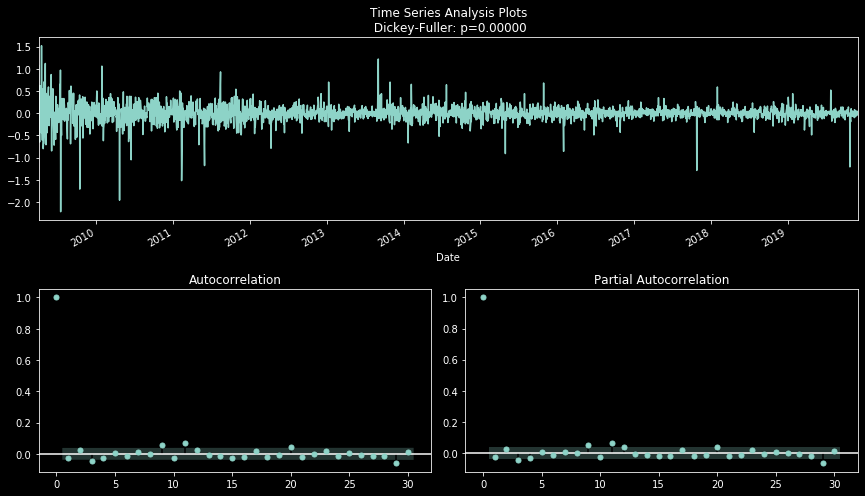

In [26]:
#Taking First difference to make the process stationary - We can decrease the autocorrelation and make the time series more 
#stationary by taking a difference of the time series by itself with a lag of 1 day
data_diff = nok.Close - nok.Close.shift(1)

tsplot(data_diff[1:], lags=30)

In [27]:
#RandomForestRegressor with scikit learn
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [28]:
 # Shift Closing price down by 700 days to predict next day
pd.concat([nok.Close, nok.Close.shift(-50)], axis=1)

,Close,Close
Date,,
2009-04-01,12.11,15.68
2009-04-02,13.18,14.96
2009-04-03,13.16,14.79
2009-04-06,13.29,14.81
2009-04-07,12.64,14.82
...,...,...
2019-11-25,3.47,NaN
2019-11-26,3.43,NaN
2019-11-27,3.46,NaN


In [29]:
#Removing the NA values from all the cells 
#Removing the timestamp from the training data as it is not relevant to the model
#Removing an unwanted column like 'Adj Close'
#Creating a training model to predict Closing price (y - dependent variable) with the help 
#of other columns (X - independent variables)
def valid(col):
    return 'Date' not in col and col != 'Adj_Close_'
nok = nok.dropna()
X = nok[[x for x in nok.columns if valid(x)]].iloc[:-50]
y = nok.Close.shift(-50).dropna()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [30]:
# Create a model 
rf_model = RandomForestRegressor()

In [31]:
# Train the model
rf_model.fit(X_train, y_train)

C:\Users\keert\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [32]:
#We can predict upto 50 days in the future in order to maintain an accuracy of 80% or more
rf_model.score(X_test, y_test)

0.8614981896679623